# Efficient DL: Gradio framework

![gradio_logo](gradio_logo.png)
## What is Gradio:
Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!
## paper
[Gradio: Hassle-Free Sharing and Testing of ML Models in the Wild. 2019](https://arxiv.org/abs/1906.02569)
## links:
- Main site: https://gradio.app/
- github: https://github.com/gradio-app/gradio  14.5 K Stars


In [1]:
%env CUDA_VISIBLE_DEVICES=4
%env GRADIO_ANALYTICS_ENABLED=false

import gradio as gr

import numpy as np
import torch
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

env: CUDA_VISIBLE_DEVICES=4
env: GRADIO_ANALYTICS_ENABLED=false


# Hello world demo

In [2]:
def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")

demo.launch(debug=False, share=False) 

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [3]:
demo.close()

Closing server running on port: 7862


# DEMO NER

In [4]:
from transformers import pipeline

import gradio as gr

ner_pipeline = pipeline(task="ner", model='dbmdz/bert-large-cased-finetuned-conll03-english', device=device)

def ner(text):
    output = ner_pipeline(text)
    return {"text": text, "entities": output}    

examples = [
    ["Moscow is the capital of Russia."],
    ["Major Tom happily lives in Houston and drinks Corona beer."],
    ["Borat Sagdiev is a famous journalist from Kazakhstan"],
    
]
demo = gr.Interface(ner,
             gr.Textbox(placeholder="Enter sentence here..."), 
             gr.HighlightedText(),
             examples=examples)

demo.launch(share=False)

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [5]:
demo.close()
# gr.close_all()

Closing server running on port: 7862


# More complex app with tabs and pictures

In [6]:
# NLP components
%env TOKENIZERS_PARALLELISM=false
from transformers import pipeline

pipe_en2es = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es", device=device)

def en2es(text):
    return pipe_en2es(text)[0]["translation_text"]

pipe_ner = pipeline(task="ner", model='dbmdz/bert-large-cased-finetuned-conll03-english', device=device)

def ner(text):
    output = pipe_ner(text)
    return {"text": text, "entities": output} 

env: TOKENIZERS_PARALLELISM=false


In [7]:
# IMAGE COMPONENTS

import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights

from PIL import Image, ImageDraw, ImageFont, UnidentifiedImageError
import requests
import io

from itertools import permutations
colors = [*permutations((255, 0, 0)), *permutations((255, 128, 0)), *permutations((255, 128, 128))]

COCO_CLASSES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus",
    "train", "truck", "boat", "traffic light", "fire hydrant", "N/A", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "N/A", "backpack", "umbrella", "N/A", "N/A",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "N/A", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza",
    "donut", "cake", "chair", "couch", "potted plant", "bed", "N/A", "dining table",
    "N/A", "N/A", "toilet", "N/A", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "N/A", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]


def img_from_url(url):
    data = requests.get(url).content
    return Image.open(io.BytesIO(data)).convert('RGB')


def object_detection(img, threshold=0.5):
    # Transform the image
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    with torch.no_grad():
        predictions = obj_detection_model(img_tensor.to(device))

    boxes = predictions[0]["boxes"]
    labels = predictions[0]["labels"]
    scores = predictions[0]["scores"]

    img_np = T.ToPILImage()(img_tensor.squeeze(0))
    draw = ImageDraw.Draw(img_np)
    font = ImageFont.truetype("RobotoCondensed-Bold.ttf", 30)
    # font = ImageFont.load_default()

    for i in range(boxes.size(0)):
        if scores[i] >= threshold:
            box = boxes[i].tolist()
            label = COCO_CLASSES[labels[i].item()]
            # color = colors[labels[i].item() % len(colors)]
            color = (128, 255, 0)

            draw.rectangle(box, outline=color, width=2)
            draw.text((box[0] + 5, box[1]), label, fill=color, font=font)
    return img_np


obj_detection_model = fasterrcnn_mobilenet_v3_large_fpn(weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT).to(device)
obj_detection_model.eval();

In [8]:
# MAIN

with gr.Blocks() as demo:
    gr.Markdown("Flip text or image files using this demo.")
    with gr.Tab("Image"):
        with gr.Row():
            with gr.Column():
                image_input = gr.Image()
                url_input = gr.Textbox(value='https://loremflickr.com/720/720/people')
                b0_url = gr.Button("from URL") 

                with gr.Row():
                    # b0_flip = gr.Button("Flip Image")
                    b0_det = gr.Button("detect")

                sli = gr.Slider(0, 1.0, value=0.5, step=0.1, label='threshold')
                
                gr.Markdown("## URL Examples")
                gr.Examples(
                    [['https://loremflickr.com/720/720/fish'], 
                     ['https://loremflickr.com/720/720/cats'], 
                     ['https://loremflickr.com/720/720/children'], 
                     ['https://www.buildyouraquarium.com/wp-content/uploads/2020/02/types-of-clownfish.jpg']],
                    [url_input,],
                )
                    
            image_output = gr.Image(shape=())
            

    with gr.Tab("NLP"):
        text_input = gr.Textbox()
        with gr.Row():
            b1_upper = gr.Button("Uppercase")
            b1_lower = gr.Button("Lowercase")
            b1_flip = gr.Button("Flip")
            b1_en2es = gr.Button("En -> Es")
            b1_ner = gr.Button("NER")
        text_output = gr.HighlightedText()
        gr.Markdown("## Text Examples")
        gr.Examples(
            [['The cat named Bat sat on the mat in Islamabad.'],
             ['Borat Sagdiev is a famous journalist from Kazakhstan.'],
            ],
            [text_input,],
        )

    def imgprn(img):
        print(img.shape, type(img))
        return img
        
    # b0_flip.click(lambda x: np.fliplr(x), inputs=image_input, outputs=[image_input, image_output])
    b0_url.click(img_from_url, inputs=url_input, outputs=image_input)
    b0_det.click(object_detection, inputs=[image_input, sli], outputs=image_output)

    b1_upper.click(lambda x: x.upper(), inputs=text_input, outputs=text_output)
    b1_lower.click(lambda x: x.lower(), inputs=text_input, outputs=text_output)
    b1_flip.click(lambda x: x[::-1], inputs=text_input, outputs=text_output)
    b1_flip.click(imgprn, inputs=text_input, outputs=text_output)
    b1_en2es.click(en2es, inputs=text_input, outputs=text_output)
    b1_ner.click(ner, inputs=text_input, outputs=text_output)

    
demo.launch(share=False)

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [9]:
demo.close()

Closing server running on port: 7862


# using Gradio projects from Huggingface Spaces

https://huggingface.co/spaces/savasy/Multilingual-Zero-Shot-Sentiment-Classification

In [10]:
gr.Interface.load("spaces/savasy/Multilingual-Zero-Shot-Sentiment-Classification").launch()

Fetching Space from: https://huggingface.co/spaces/savasy/Multilingual-Zero-Shot-Sentiment-Classification


/home/optimus/conda/envs/py9/lib/python3.9/site-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Label, please remove them: {'selectable': False}
  warnings.warn(


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [11]:
gr.close_all()

Closing server running on port: 7862
Closing server running on port: 7862


# Interactive Sine curve

In [14]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt

def plot_sine_curve(amplitude, frequency, phase, offset):
    x = np.linspace(0, 2 * np.pi, 100)
    y = amplitude * np.sin(frequency * x + phase) + offset

    plt.plot(x, y)
    plt.xlim(0, 2 * np.pi)
    plt.ylim(-10, 10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Sine Curve')
    plt.grid()

    plt.savefig("sine_curve.png")
    plt.close()
    return "sine_curve.png"

demo = gr.Interface(
    fn=plot_sine_curve,
    inputs=[
        gr.components.Slider(minimum=0, maximum=10, step=0.1, value=1, label="Amplitude"),
        gr.components.Slider(minimum=0, maximum=10, step=0.1, value=1, label="Frequency"),
        gr.components.Slider(minimum=0, maximum=2 * np.pi, step=0.1, value=0, label="Phase"),
        gr.components.Slider(minimum=-10, maximum=10, step=0.1, value=0, label="Offset"),
    ],
    outputs=gr.components.Image(type="pil", label="Sine Curve"),
    title="Sine Curve Plotter",
    description="Adjust the sine curve parameters using sliders and see the output plot.",
    live=True,  # << this parameter makes the app instantly reactive
)

demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


### API call

In [22]:
import requests

response = requests.post("http://127.0.0.1:7863/run/predict", json={
	"data": [
		3,
		9,
		1,
		0,
	]
}).json()

data = response["data"]

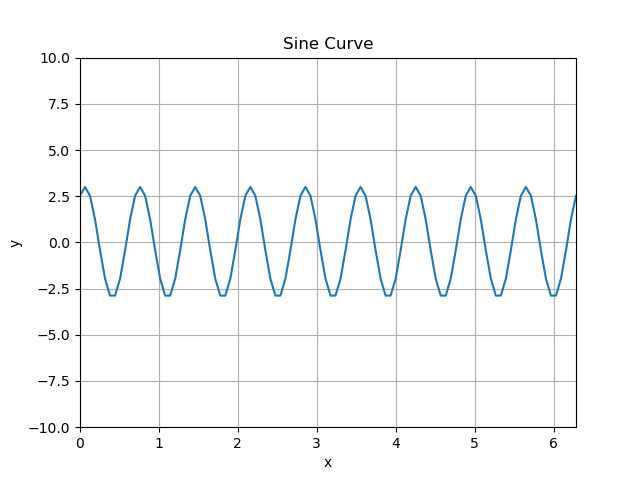

In [23]:
import base64
from PIL import Image
from io import BytesIO
import IPython.display as display

encoded_image = data[0].split(',')[1]
image_data = base64.b64decode(encoded_image)
image = Image.open(BytesIO(image_data))
display.display(image)

In [24]:
demo.close()

Closing server running on port: 7863


# Sketching in Gradio
https://huggingface.co/spaces/gradio/pictionary

![gradio_pictionary](gradio_pictionary.png)

# Complex gradio project:
web UI for Stable Diffusion from Automatic 1111 https://github.com/AUTOMATIC1111/stable-diffusion-webui

![auto1111_screenshot](auto1111_screenshot.png)

# Mapping APP
https://huggingface.co/spaces/gradio/map_airbnb

![mapping](mapping_app.png)

# Other cool features of Gradio:
  ### - Stateful web applications
  ### - Integration with databases
  ### - Plotting
### - speech / video components
### - styling with CSS